In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
from torch.utils.data import random_split

In [2]:
#Use the ResNet18 on Cifar-10
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#set hyperparameter
EPOCH = 10
pre_epoch = 0
BATCH_SIZE = 16
LR = 0.001


cuda


#### Transformer

In [3]:
# 训练数据的 transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0,translate=(0.05,0.05)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 测试数据的 transforms
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [4]:
data_path = "./training/"

dataset = torchvision.datasets.ImageFolder(data_path)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [5]:
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_test

In [6]:

trainloader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

testloader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

import os
classes = list(os.listdir(data_path))[1:] 
classes

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spyder',
 'squirrel']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


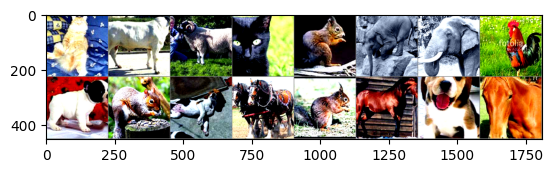

cat   cow   sheep cat   squirrel elephant elephant chicken dog   squirrel dog   horse squirrel horse dog   horse


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

# print(images.shape)

In [8]:
#define model
net = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)

net.fc = nn.Linear(in_features=1280, out_features=10)
net = net.to(device)
print(net)

#define loss function & optimizer
optimizer = optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
from tqdm import tqdm

In [10]:
scaler = GradScaler()

#train
for epoch in range(pre_epoch, EPOCH):
    print(f"\nEpoch: {epoch + 1}")
    net.train()
    sum_loss, correct, total= 0.0, 0.0, 0.0
    
    
    with tqdm(trainloader , unit="batch" ,desc='Training') as t_epoch:
        for (inputs, labels) in t_epoch:
            torch.cuda.empty_cache()
            
            #prepare dataset
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            #forward & backward
            with torch.cuda.amp.autocast():
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            
            #print ac & loss in each batch
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()
    
    train_acc = 100.0 * correct / total
    
    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct , total = 0, 0
        
        with tqdm(testloader , unit="batch" ,desc='Testing') as t_epoch_test:
            for (images, labels) in t_epoch_test:
                torch.cuda.empty_cache()
                net.eval()

                images, labels = images.to(device), labels.to(device)
                
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()
        
        print(f'[epoch:{epoch+1}] Loss: {loss:.3f} | Train Acc: {train_acc:.3f} | Test Acc :  {(100 * correct / total):.3f}')

print(f"Train has finished, total epoch is {EPOCH}")


Epoch: 1


Training: 100%|██████████| 1257/1257 [08:58<00:00,  2.33batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:41<00:00,  7.68batch/s]


[epoch:1] Loss: 0.391 | Train Acc: 75.058 | Test Acc :  84.368

Epoch: 2


Training: 100%|██████████| 1257/1257 [08:18<00:00,  2.52batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:40<00:00,  7.78batch/s]


[epoch:2] Loss: 0.830 | Train Acc: 85.018 | Test Acc :  86.754

Epoch: 3


Training: 100%|██████████| 1257/1257 [08:17<00:00,  2.52batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:40<00:00,  7.72batch/s]


[epoch:3] Loss: 1.027 | Train Acc: 88.131 | Test Acc :  87.709

Epoch: 4


Training: 100%|██████████| 1257/1257 [08:12<00:00,  2.55batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:40<00:00,  7.82batch/s]


[epoch:4] Loss: 0.477 | Train Acc: 89.956 | Test Acc :  90.076

Epoch: 5


Training: 100%|██████████| 1257/1257 [08:17<00:00,  2.53batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:40<00:00,  7.75batch/s]


[epoch:5] Loss: 0.677 | Train Acc: 91.626 | Test Acc :  91.388

Epoch: 6


Training: 100%|██████████| 1257/1257 [08:19<00:00,  2.52batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:40<00:00,  7.85batch/s]


[epoch:6] Loss: 0.153 | Train Acc: 92.889 | Test Acc :  88.186

Epoch: 7


Training: 100%|██████████| 1257/1257 [08:17<00:00,  2.53batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:40<00:00,  7.73batch/s]


[epoch:7] Loss: 0.004 | Train Acc: 93.944 | Test Acc :  89.618

Epoch: 8


Training: 100%|██████████| 1257/1257 [08:15<00:00,  2.53batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:40<00:00,  7.77batch/s]


[epoch:8] Loss: 0.035 | Train Acc: 94.361 | Test Acc :  89.499

Epoch: 9


Training: 100%|██████████| 1257/1257 [08:14<00:00,  2.54batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:40<00:00,  7.76batch/s]


[epoch:9] Loss: 0.158 | Train Acc: 95.231 | Test Acc :  91.368

Epoch: 10


Training: 100%|██████████| 1257/1257 [08:16<00:00,  2.53batch/s]


Waiting Test...


Testing: 100%|██████████| 315/315 [00:40<00:00,  7.74batch/s]

[epoch:10] Loss: 0.181 | Train Acc: 95.843 | Test Acc :  91.786
Train has finished, total epoch is 10


In [11]:
PATH = './HW4_ef_2_net.pth'
torch.save(net.state_dict(), PATH)

In [12]:
MODEL_PATH = './HW4_ef_2_net.model'
torch.save(net, MODEL_PATH)

In [13]:
torch.cuda.empty_cache()